In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import folium

In [2]:
# dữ liệu thô ban đầu sau khi vừa mới crawl
data = pd.read_csv('data/houses/houses_current.csv')
data.head()
len(data)

9674

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9674 entries, 0 to 9673
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   houseTypes  9674 non-null   object 
 1   area        9497 non-null   float64
 2   num_floors  7706 non-null   float64
 3   bedrooms    7577 non-null   float64
 4   address     9674 non-null   object 
 5   price       9548 non-null   float64
 6   url         9674 non-null   object 
dtypes: float64(4), object(3)
memory usage: 529.2+ KB


REMOVE DUPLICATES

In [4]:
print('Sum of duplicates: ', data.duplicated(subset=['houseTypes', 'area', 'num_floors', 'bedrooms','address','price']).sum())
data = data.drop_duplicates(subset=['houseTypes', 'area', 'num_floors', 'bedrooms','address','price']).copy()
print('After removing duplicates: ', data.duplicated().sum())
print('Length of data then: ', len(data))

Sum of duplicates:  1066
After removing duplicates:  0
Length of data then:  8608


CONVERT OBJECT TO FLOAT64 AND STRING

In [5]:
data = data.astype({'houseTypes':'string','address':'string','url':'string'})

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8608 entries, 0 to 9673
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   houseTypes  8608 non-null   string 
 1   area        8447 non-null   float64
 2   num_floors  6798 non-null   float64
 3   bedrooms    6698 non-null   float64
 4   address     8608 non-null   string 
 5   price       8492 non-null   float64
 6   url         8608 non-null   string 
dtypes: float64(4), string(3)
memory usage: 538.0 KB


In [7]:
for col in data.columns:
    print('Ratio of missing data of ' + str(col) +': ' + str(round(data[col].isna().sum()*100/len(data[col]),3)) + '%')

Ratio of missing data of houseTypes: 0.0%
Ratio of missing data of area: 1.87%
Ratio of missing data of num_floors: 21.027%
Ratio of missing data of bedrooms: 22.189%
Ratio of missing data of address: 0.0%
Ratio of missing data of price: 1.348%
Ratio of missing data of url: 0.0%


In [8]:
data[['district','city']] = data['address'].apply(lambda x: pd.Series(str(x).split(', ')))


In [9]:
data = data.drop(['address'], axis=True)

In [10]:
data.reset_index(inplace=True, drop=True)

In [11]:
data = data[['houseTypes','area','num_floors','bedrooms','district','city','price','url']]

In [12]:
data.head()

,houseTypes,area,num_floors,bedrooms,district,city,price,url
0,Bán Nhà riêng,130.0,3.0,7.0,Quận 12,TP Hồ Chí Minh,9.200,https://batdongsan.vn/ban-biet-thu-san-vuon-qu...
1,Bán Nhà riêng,65.0,NaN,2.0,Ngũ Hành Sơn,Đà Nẵng,2.900,https://batdongsan.vn/29-ty-dien-tich-6580m2-n...
2,Bán Nhà riêng,90.0,5.0,5.0,Hai Bà Trưng,Hà Nội,14.000,https://batdongsan.vn/ban-nha-kim-nguu-phan-lo...
3,Bán Nhà riêng,50.0,5.0,5.0,Quận 3,TP Hồ Chí Minh,0.001,https://batdongsan.vn/quan-3-le-van-sy-5-tang-...
4,Bán Nhà riêng,30.0,1.0,2.0,Gò Vấp,TP Hồ Chí Minh,3.700,https://batdongsan.vn/nha-moi-full-noi-that-hx...


In [ ]:
# data.to_csv('data/houses/houses.csv',index=False)
# data.to_excel('data/houses/houses.xlsx',index=False)

## Xử lí giá

In [14]:
data.price.describe()

count     8492.000000
mean       179.531718
std       2044.588083
min          0.000000
25%          3.650000
50%          5.450000
75%          8.500000
max      89440.000000
Name: price, dtype: float64

In [15]:
low_noise_data = data.loc[(data['price'] < 0.1)]
hign_noise_data = data.loc[(data['price'] >= 500)]
null_price_data = data[data['price'].isna()]

C:\Users\84947\AppData\Local\Temp\ipykernel_18548\958291345.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(house_data_1['price'])


<AxesSubplot: xlabel='price', ylabel='Density'>

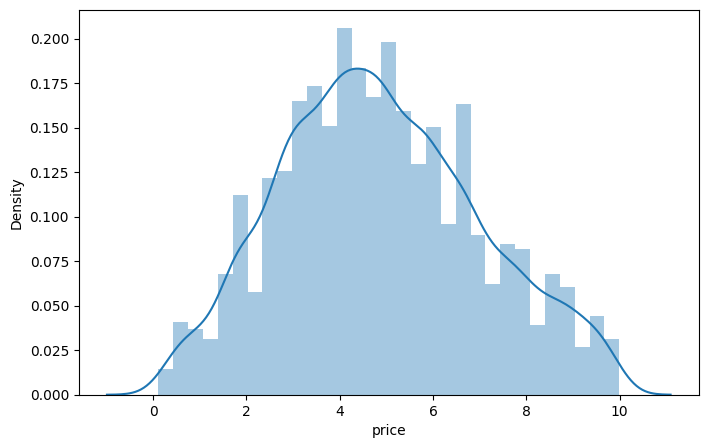

In [16]:
house_data_1 = data.loc[(data['price'] >= 0.1) & (data['price'] < 10)]
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data_1['price'])

In [ ]:
house_data_2 = data.loc[(data['price'] >= 0.1) & (data['price'] < 50)]
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data_2['price'])

In [17]:
house_data = data.loc[(data['price'] >= 0.1) & (data['price'] < 500)]

C:\Users\84947\AppData\Local\Temp\ipykernel_18548\3740483212.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(house_data['price'])


<AxesSubplot: xlabel='price', ylabel='Density'>

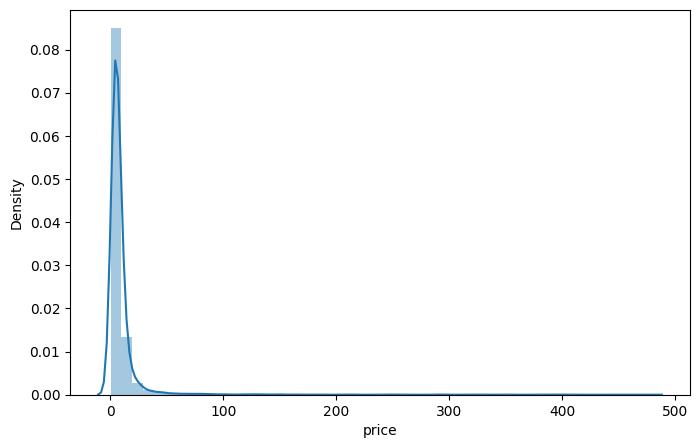

In [18]:
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data['price'])

## Xử lí area

In [19]:
house_data['area'].isna().sum()

124

In [20]:
house_data['area'].describe()

count      8142.000000
mean         97.477207
std        1148.948237
min           3.000000
25%          43.000000
50%          58.000000
75%          84.000000
max      100103.000000
Name: area, dtype: float64

In [21]:
house_data = house_data.loc[(house_data['area'] >= 10) & (house_data['area'] <= 20000)]

In [22]:
house_data['area'].describe()

count     8096.000000
mean        85.640689
std        303.197151
min         10.000000
25%         44.000000
50%         59.000000
75%         85.000000
max      18264.000000
Name: area, dtype: float64

C:\Users\84947\AppData\Local\Temp\ipykernel_18548\255560388.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(house_data_3['area'])


<AxesSubplot: xlabel='area', ylabel='Density'>

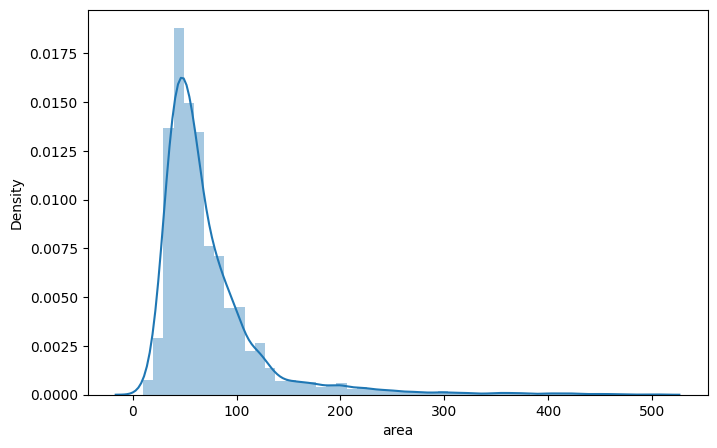

In [23]:
house_data_3 = house_data.loc[(house_data['area'] >=10) & (house_data['area'] <=500)]
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data_3['area'])

In [ ]:
# house_data.to_excel('data/houses/house_data.xlsx', index=False)

# Thử nghiệm KNN cho missing values

In [24]:
not_null_houses = house_data.dropna() # phải lấy house_data lúc còn null (trước khi fill ở phần trên)
not_null_houses.to_excel('data/not_null_houses.xlsx',index=False)

In [25]:
i1 = np.random.choice(a=not_null_houses.index, size=50)
i2 = np.random.choice(a=not_null_houses.index, size=50)
print(i1)
print(i2)

[2900 8112 4245 5976 8052 6496 5385 3489  454 6861 5884 5003 7817 8299
 8532 4379 1275 3093 1004 3619 4624 6493 3933  405 4769 6338 1388 2018
 3793 3328 5596 7378 4402  168 6816 3994 5222 4297  238 7029 2002 7853
 1848 6251 7711 1635 8019 5675  854 5227]
[2507 5698 5610 3192 1987 3258 3407 8521 3609 5886 7778 1041 3900 4371
 4872 7874 5576 1453 7353 6033 5385 5995 4861 4595 2397 5604 3963 3853
 3261 3857 8560 6970 6966 8102 6718 6962 3807 5192 8213 4571 3047 3749
 8202 7027 8020 4847 8090 1060 4662 7625]


In [26]:
null_houses = pd.DataFrame({'area':not_null_houses['area'],'num_floors':not_null_houses['num_floors'],'bedrooms':not_null_houses['bedrooms'],'price':not_null_houses['price']})
null_houses.isna().sum()

area          0
num_floors    0
bedrooms      0
price         0
dtype: int64

In [27]:
null_houses.loc[i1, 'num_floors'] = np.nan
null_houses.loc[i2, 'bedrooms'] = np.nan

In [ ]:
#null_houses.loc[164]

In [28]:
null_houses.isna().sum()

area           0
num_floors    50
bedrooms      50
price          0
dtype: int64

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

In [30]:
def optimize_k(data, target):
    errors = []
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=data.columns)
        
        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        
    return errors

In [31]:
k_errors = optimize_k(data=null_houses, target='price')
print(k_errors)

[{'K': 1, 'RMSE': 21.841359935259067}, {'K': 3, 'RMSE': 21.91491982375839}, {'K': 5, 'RMSE': 21.749483380478274}, {'K': 7, 'RMSE': 21.864821464606518}, {'K': 9, 'RMSE': 21.842963871959206}, {'K': 11, 'RMSE': 21.817935256136714}, {'K': 13, 'RMSE': 21.91128703686379}, {'K': 15, 'RMSE': 21.86555637149899}, {'K': 17, 'RMSE': 21.792904769792496}, {'K': 19, 'RMSE': 21.820829972184445}]


In [32]:
imputer_test = KNNImputer(n_neighbors=13)
imputed_test = imputer_test.fit_transform(null_houses)
df_imputed_test = pd.DataFrame(imputed_test, columns=null_houses.columns)

In [33]:
df_imputed_test.isna().sum()
# df_imputed_test.to_excel('data/df_imputed_test.xlsx',index=False)

area          0
num_floors    0
bedrooms      0
price         0
dtype: int64

Note: so sánh not_null_houses.xlsx và df_imputed_test.xlsx

# Xử lý num_floors và bedrooms

In [34]:
house_data.isna().sum()

houseTypes       0
area             0
num_floors    1680
bedrooms      1709
district         0
city             0
price            0
url              0
dtype: int64

In [35]:
house_data.loc[house_data['num_floors'] > 11, 'num_floors'] = None
house_data.isna().sum()

houseTypes       0
area             0
num_floors    1700
bedrooms      1709
district         0
city             0
price            0
url              0
dtype: int64

In [ ]:
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data['num_floors'])

In [ ]:
fig,ax = plt.subplots(figsize = (8,5))
sns.distplot(house_data['bedrooms'])

In [38]:
numeric_houses = pd.DataFrame({'area':house_data['area'],'num_floors':house_data['num_floors'],'bedrooms':house_data['bedrooms'],'price':house_data['price']})
numeric_houses.isna().sum()

area             0
num_floors    1700
bedrooms      1709
price            0
dtype: int64

In [39]:
len(numeric_houses)

8096

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer

rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))

In [41]:
def optimize_k(data, target):
    errors = []
    for k in range(1, 20):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=data.columns)
        
        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        
    return errors

In [42]:
test_numeric_house = numeric_houses.copy()
test_numeric_house.isna().sum()

area             0
num_floors    1700
bedrooms      1709
price            0
dtype: int64

In [43]:
k_errors = optimize_k(data=test_numeric_house, target='price')
print(k_errors)

[{'K': 1, 'RMSE': 17.185648898115417}, {'K': 2, 'RMSE': 19.035485826854682}, {'K': 3, 'RMSE': 19.419293608152653}, {'K': 4, 'RMSE': 18.987811956783005}, {'K': 5, 'RMSE': 18.5030230859601}, {'K': 6, 'RMSE': 19.38474829235847}, {'K': 7, 'RMSE': 18.241578195953426}, {'K': 8, 'RMSE': 18.37251125271719}, {'K': 9, 'RMSE': 18.367555570957645}, {'K': 10, 'RMSE': 18.701396705191005}, {'K': 11, 'RMSE': 18.465131921541083}, {'K': 12, 'RMSE': 18.158279674269153}, {'K': 13, 'RMSE': 17.557523559151587}, {'K': 14, 'RMSE': 17.5500630983315}, {'K': 15, 'RMSE': 17.823846047184052}, {'K': 16, 'RMSE': 17.769257005187967}, {'K': 17, 'RMSE': 17.29898195650341}, {'K': 18, 'RMSE': 17.733370459502293}, {'K': 19, 'RMSE': 17.850699955777085}]


In [44]:
imputer = KNNImputer(n_neighbors=17)
imputed = imputer.fit_transform(numeric_houses)
df_imputed = pd.DataFrame(imputed, columns=numeric_houses.columns)

In [45]:
df_imputed.isna().sum()

area          0
num_floors    0
bedrooms      0
price         0
dtype: int64

In [ ]:
df_imputed['bedrooms'].describe()

In [ ]:
# numeric_houses.to_excel('numeric_houses.xlsx',index=False)
# df_imputed.to_excel('df_imputed.xlsx',index=False)

In [46]:
house_data = house_data.reset_index()

In [47]:
house_data['new_num_floors'] = df_imputed['num_floors'].round(0)
house_data['new_bedrooms'] = df_imputed['bedrooms'].round(0)

In [48]:
house_data.isna().sum()

index                0
houseTypes           0
area                 0
num_floors        1700
bedrooms          1709
district             0
city                 0
price                0
url                  0
new_num_floors       0
new_bedrooms         0
dtype: int64

In [51]:
house_data.drop(['url','index','num_floors','bedrooms'],axis=1,inplace=True)
house_data = house_data[['houseTypes','area','new_num_floors','new_bedrooms','district','city','price']]

In [55]:
house_data.to_excel('full_houses.xlsx', index=False)
house_data

,houseTypes,area,new_num_floors,new_bedrooms,district,city,price
0,Bán Nhà riêng,130.0,3.0,7.0,Quận 12,TP Hồ Chí Minh,9.20
1,Bán Nhà riêng,65.0,2.0,2.0,Ngũ Hành Sơn,Đà Nẵng,2.90
2,Bán Nhà riêng,90.0,5.0,5.0,Hai Bà Trưng,Hà Nội,14.00
3,Bán Nhà riêng,30.0,1.0,2.0,Gò Vấp,TP Hồ Chí Minh,3.70
4,Bán Nhà riêng,38.0,3.0,3.0,Bình Thạnh,TP Hồ Chí Minh,4.40
...,...,...,...,...,...,...,...
8091,Bán Nhà riêng,61.0,3.0,4.0,Gò Vấp,TP Hồ Chí Minh,9.50
8092,Bán Nhà riêng,64.0,3.0,5.0,Bình Thạnh,TP Hồ Chí Minh,9.50
8093,Bán Nhà riêng,60.0,3.0,3.0,Tân Phú,TP Hồ Chí Minh,5.40
8094,Bán Nhà riêng,90.0,2.0,2.0,Biên Hòa,Đồng Nai,2.85


# Encoding

In [60]:
house_data = pd.read_excel('full_houses.xlsx')

In [61]:
import category_encoders as ce

# encoding city
target_encoder =ce.TargetEncoder() 
new = target_encoder.fit_transform(house_data[['city','district','houseTypes']],house_data['price'])
new = new.rename(columns={'city':'city_encoder','district':'district_encoder','houseTypes':'houseTypes_encoder'})
data_encoded = pd.concat([house_data, new], axis=1)


# Xóa các cột gốc trong biến data
data_encoded.drop(['houseTypes','city','district'], axis=1, inplace=True)


print(data_encoded.head(10))

    area  new_num_floors  new_bedrooms  price  city_encoder  district_encoder  \
0  130.0               3             7    9.2      9.292954          8.661038   
1   65.0               2             2    2.9      7.417350          7.708597   
2   90.0               5             5   14.0     11.089988          8.835714   
3   30.0               1             2    3.7      9.292954          6.731978   
4   38.0               3             3    4.4      9.292954         11.315324   
5   45.0               2             2    3.9      9.292954          7.525423   
6   51.0               6             4   12.7      9.292954          6.731978   
7   50.0               4             4   25.0     11.089988         14.754023   
8  160.0               3             3    4.5      8.617771          8.617771   
9   48.0               5             4    7.4      9.292954          6.731978   

   houseTypes_encoder  
0            7.343849  
1            7.343849  
2            7.343849  
3           

In [62]:
area_lower, area_upper = data_encoded.area.mean() - data_encoded.area.std()*3, data_encoded.area.mean() + data_encoded.area.std()*3
floor_lower, floor_upper = data_encoded.new_num_floors.mean() - data_encoded.new_num_floors.std()*3, data_encoded.new_num_floors.mean() + data_encoded.new_num_floors.std()*3
bedroom_lower, bedroom_upper = data_encoded.new_bedrooms.mean() - data_encoded.new_bedrooms.std()*3, data_encoded.new_bedrooms.mean() + data_encoded.new_bedrooms.std()*3
city_lower, city_upper = data_encoded.city_encoder.mean() - data_encoded.city_encoder.std()*3, data_encoded.city_encoder.mean() + data_encoded.city_encoder.std()*3
district_lower, district_upper = data_encoded.district_encoder.mean() - data_encoded.district_encoder.std()*3, data_encoded.district_encoder.mean() + data_encoded.district_encoder.std()*3
type_lower, type_upper = data_encoded.houseTypes_encoder.mean() - data_encoded.houseTypes_encoder.std()*3, data_encoded.houseTypes_encoder.mean() + data_encoded.houseTypes_encoder.std()*3
price_lower, price_upper = data_encoded.price.mean() - data_encoded.price.std()*3, data_encoded.price.mean() + data_encoded.price.std()*3


In [63]:
clean_data = data_encoded.loc[(data_encoded['area'] >= area_lower) & (data_encoded['area'] <= area_upper)]
clean_data = clean_data.loc[(clean_data['new_num_floors'] >= floor_lower) & (clean_data['new_num_floors'] <= floor_upper)]
clean_data = clean_data.loc[(clean_data['new_bedrooms'] >= bedroom_lower) & (clean_data['new_bedrooms'] <= bedroom_upper)]
clean_data = clean_data.loc[(clean_data['city_encoder'] >= city_lower) & (clean_data['city_encoder'] <= city_upper)]
clean_data = clean_data.loc[(clean_data['district_encoder'] >= district_lower) & (clean_data['district_encoder'] <= district_upper)]
clean_data = clean_data.loc[(clean_data['houseTypes_encoder'] >= type_lower) & (clean_data['houseTypes_encoder'] <= type_upper)]
clean_data = clean_data.loc[(clean_data['price'] >= price_lower) & (clean_data['price'] <= price_upper)]

In [64]:
clean_data.describe()

,area,new_num_floors,new_bedrooms,price,city_encoder,district_encoder,houseTypes_encoder
count,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000,7497.000000
mean,71.332093,3.114179,3.542350,7.117202,9.441714,9.086617,9.111822
std,58.924419,1.391786,1.534676,6.909489,1.372277,2.897918,3.465229
min,10.000000,1.000000,1.000000,0.110000,4.202107,2.926135,6.407138
25%,42.000000,2.000000,3.000000,3.700000,9.292954,7.387305,7.343849
50%,56.000000,3.000000,3.000000,5.350000,9.292954,8.786364,7.343849
75%,80.000000,4.000000,4.000000,7.900000,11.089988,10.744222,7.343849
max,995.000000,7.000000,13.000000,75.000000,11.480157,16.933277,15.706045


In [69]:
clean_data.to_excel('clean_data.xlsx',index=False)

<AxesSubplot: >

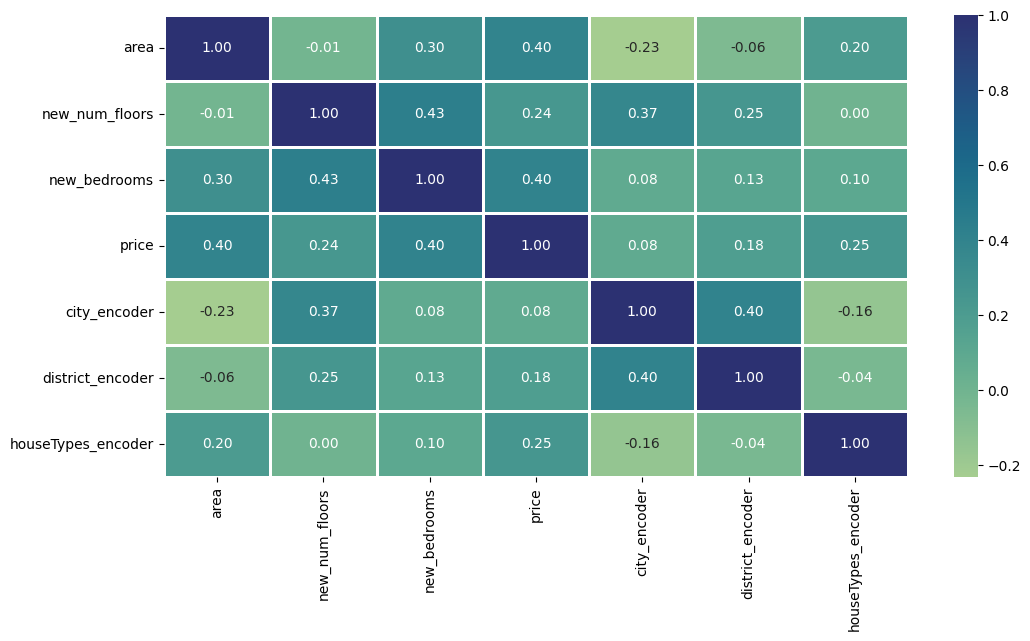

In [65]:
plt.figure(figsize=(12, 6))
sns.heatmap(clean_data.corr(), cmap="crest",fmt = '.2f',linewidths = 2,annot = True)

array([[<AxesSubplot: title={'center': 'area'}>,
        <AxesSubplot: title={'center': 'new_num_floors'}>],
       [<AxesSubplot: title={'center': 'new_bedrooms'}>,
        <AxesSubplot: title={'center': 'city_encoder'}>],
       [<AxesSubplot: title={'center': 'district_encoder'}>,
        <AxesSubplot: title={'center': 'houseTypes_encoder'}>]],
      dtype=object)

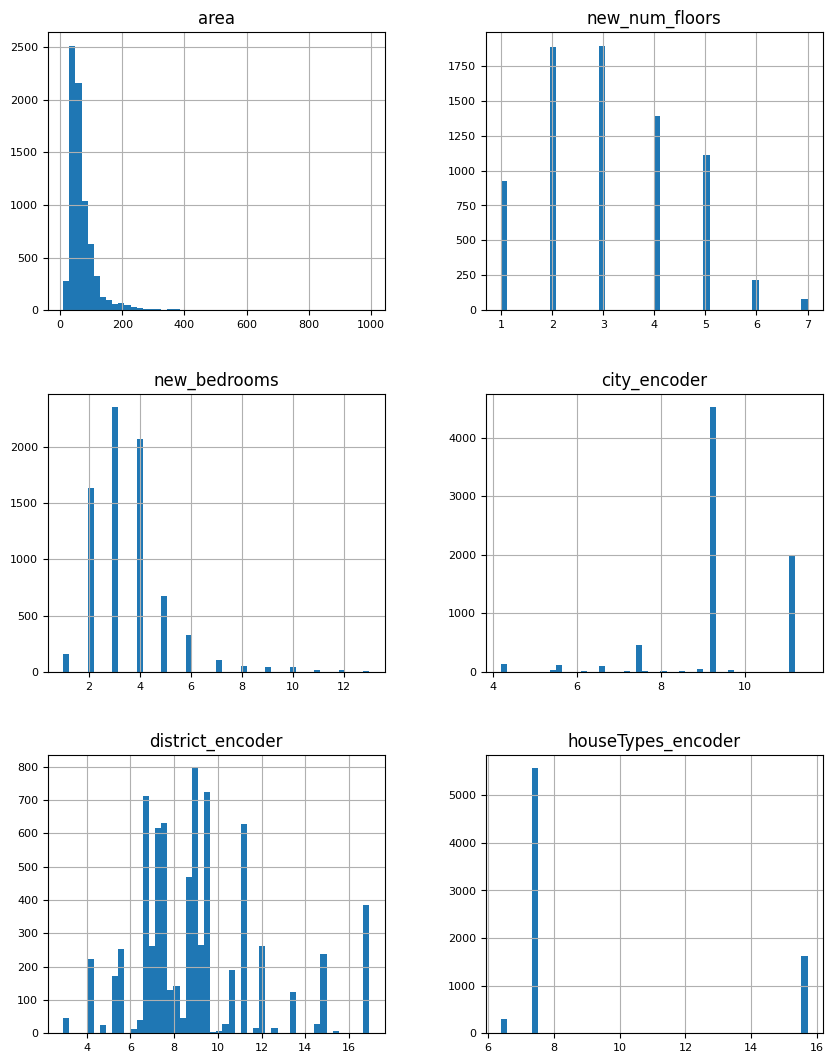

In [66]:
features = clean_data.drop(['price'], axis=True)
features.hist(figsize=(10,13), bins=50, xlabelsize=8, ylabelsize=8)

In [67]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
 
X = clean_data.drop(['price'], axis=1)
Y = clean_data['price']

X = StandardScaler().fit_transform(X.values)

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

SVM

In [68]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score,mean_absolute_percentage_error
 
model_SVR = svm.SVR()
model_SVR.fit(X_train,y_train)
y_pred = model_SVR.predict(X_test)
 

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
print(mean_absolute_percentage_error(y_test, y_pred))
print("MSE: ", mse)
print("MAE: ", mae)
print("variance: ", evs)

0.4628232312879339
MSE:  29.73815876257318
MAE:  2.4098366743985915
variance:  0.3284423194646563


RANDOM FOREST

In [70]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score,mean_absolute_percentage_error
 
model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, y_train)
y_pred = model_RFR.predict(X_test)
 
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)
print(mean_absolute_percentage_error(y_test, y_pred))
print("MSE: ", mse)
print("MAE: ", mae)
print("variance: ", evs)

0.474991042218078
MSE:  30.8066405726314
MAE:  2.566628314146238
variance:  0.2899000429226799
